In [99]:
import pylab
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

pd.options.mode.chained_assignment = None
import IPython.core.display as di
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# Items imformation

In [9]:
df_items0 = pd.read_csv("items.csv", sep = "|")
print(df_items0.shape)
df_items0.head()

(22035, 11)


,pid,manufacturer,group,content,unit,pharmForm,genericProduct,salesIndex,category,campaignIndex,rrp
0,1,1,2FOI,80,ST,TAB,0,40,NaN,NaN,10.89
1,2,1,2FOI,80,ST,Tab,0,40,NaN,NaN,10.89
2,3,1,2FOI,10,G,GLO,0,40,NaN,NaN,16.45
3,4,1,2FOI,80,ST,TAB,0,40,NaN,NaN,10.89
4,5,2,10OJ03JS,8,ST,PUL,0,40,1.0,NaN,22.53


1. pid: 商品編號  
2. manufacturer: 供應廠商  
3. group: 藥品分類  
4. content: 幾乘幾  
5. unit: 容量單位  
6. pharmForm: 藥品型態  
7. genericProduct: 是否為基因產品  
8. salesIndex: 配送規則代碼  
9. category: Main shop category  
10. rrp: reference price

In [29]:
def missing(df):
    print('Size of testing dataset : %d' % (df.shape[0]))
    df1 = df.dropna()
    print('Size of testing dataset DropNA : %d' % (df1.shape[0]))
    display(df.isnull().sum())

In [30]:
missing(df_items0)

Size of testing dataset : 22035
Size of testing dataset DropNA : 15715


pid                  0
manufacturer         0
group                0
content              0
unit                 0
pharmForm         2327
genericProduct       0
salesIndex           0
category          4627
rrp                  0
dtype: int64

In [10]:
### 大部分的campaignIndex都是遺失值，所以刪除
del df_items0["campaignIndex"]
### 將大小寫統一
df_items0.pharmForm = df_items0.pharmForm.str.upper()

In [11]:
### 處理content的資料型態
content = pd.DataFrame(df_items0.content.str.split('X',2).tolist(), columns = ['x','y','z'])
content = content.fillna('1')
content.x = pd.to_numeric(content.x, errors='coerce')
content.y = pd.to_numeric(content.y, errors='coerce')
content.z = pd.to_numeric(content.z, errors='coerce')
content['Content'] = content.x * content.y * content.z
df_items1 = pd.concat([df_items0, content], axis=1, join_axes=[df_items0.index])
del df_items1["x"]
del df_items1["y"]
del df_items1["z"]
del df_items1["content"]

### 將categorical columns轉成數字型態
df_items1.group = df_items1.group.astype("category").cat.codes
df_items1.unit = df_items1.unit.astype("category").cat.codes
df_items1.pharmForm = df_items1.pharmForm.astype("category").cat.codes
#df_items = pd.get_dummies(df_items)

df_items1.head()

,pid,manufacturer,group,unit,pharmForm,genericProduct,salesIndex,category,rrp,Content
0,1,1,529,7,135,0,40,NaN,10.89,80.0
1,2,1,529,7,135,0,40,NaN,10.89,80.0
2,3,1,529,1,45,0,40,NaN,16.45,10.0
3,4,1,529,7,135,0,40,NaN,10.89,80.0
4,5,2,74,7,112,0,40,1.0,22.53,8.0


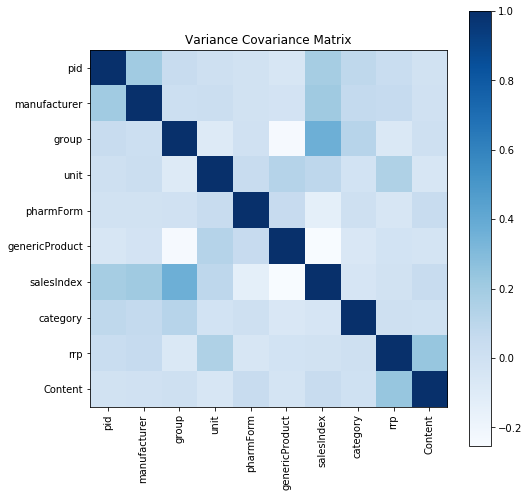

In [12]:
df_items1.corr()

plt.figure(num=None, figsize=(8, 8))
plt.imshow(df_items1.corr(), cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
tick_marks = [i for i in range(len(df_items1.columns))]
plt.xticks(tick_marks, df_items1.columns, rotation='vertical')
plt.yticks(tick_marks, df_items1.columns)
plt.title('Variance Covariance Matrix', fontsize = 12)

plt.show()

> 商品的變數之間關聯性低

## Feature Extraction

In [26]:
### dummy varible(categorical varible)
def onehot1(df):
    onehot = np.array(pd.get_dummies(df))
    original_dim = onehot.shape[1]
    print('original dimension : %d' % onehot.shape[1])
    return onehot, original_dim

### dummy varible(number categorical varible)
def onehot2(df):
    df_le = pd.DataFrame(np_utils.to_categorical(df,(max(df)+1)))
    original_dim = df_le.shape[1]
    print('original dimension : %d' % df_le.shape[1])
    return df_le, original_dim

def auto(df, dim):
    from keras.layers import Input, Dense
    from keras.models import Model
    from keras.callbacks import TensorBoard
    encoding_dim = dim

    input_img = Input(shape=(df.shape[1],))
    encoded = Dense(2000, activation='relu')(input_img)
    encoded = Dense(1000, activation='relu')(encoded)
    encoded = Dense(500, activation='relu')(encoded)
    encoded = Dense(encoding_dim, activation='relu')(encoded)

    decoded = Dense(500, activation='relu')(encoded)
    decoded = Dense(1000, activation='relu')(decoded)
    decoded = Dense(2000, activation='relu')(decoded)
    decoded = Dense(df.shape[1], activation='sigmoid')(decoded)

    autoencoder = Model(input = input_img, output = decoded)
    autoencoder.compile(optimizer = 'adadelta', loss = 'binary_crossentropy')
    history = autoencoder.fit(df, df,
                              nb_epoch = nb_epoch,
                              batch_size = 256,
                              shuffle = True,
                              verbose = 0,
                              validation_split = 0.2)
    from keras import backend as K
    target_layer = K.function(autoencoder.inputs, [autoencoder.layers[4].output])
    ## Extract output from the target hidden layer.
    target_layer_out = target_layer([df])
    df_auto = pd.DataFrame(np.array(target_layer_out[0]))
    print('encoding dimension : %d' % (df_auto.shape[1]))
    return history, df_auto

def Plot(train_value, test_value, value_is_loss_or_acc):
    f, ax = plt.subplots()
    ax.plot([None] + train_value, 'o-')
    ax.plot([None] + test_value, 'x-')
    ax.legend(['Train ' + value_is_loss_or_acc, 'Validation ' + value_is_loss_or_acc], loc = 0) 
    ax.set_title('Training/Validation ' + value_is_loss_or_acc + ' per Epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(value_is_loss_or_acc)  
    plt.show()

def F1(x):
    df_onehot, original_dim = onehot1(x)
    df_his, df_auto = auto(df_onehot, int(original_dim/10))
    Plot(df_his.history['loss'], df_his.history['val_loss'], 'Loss')
    return df_auto

def F2(x):
    df_onehot, original_dim = onehot2(x)
    df_his, df_auto = auto(np.array(df_onehot), int(original_dim/10))
    Plot(df_his.history['loss'], df_his.history['val_loss'], 'Loss')
    return df_auto

### 1. Dummies Varibles

In [90]:
g1, g1_dim = onehot2(df_items1.group)
p1, p1_dim = onehot2(df_items1.pharmForm)
u1, u1_dim = onehot2(df_items1.unit)
m1, m1_dim = onehot2(df_items1.manufacturer)
s1, s1_dim = onehot2(df_items1.salesIndex)

df_items_oh0 = pd.concat([df_items1, g1, p1, u1, m1, s1], axis=1, join_axes=[df_items1.index])
df_items_oh = df_items_oh0.drop(["group", "pharmForm", "unit", "manufacturer", "salesIndex"], axis=1)
df_items_oh.columns = [np.arange(1, (pd.DataFrame(df_items_oh).shape[1]+1), 1)]
df_items_oh.rename(columns={1: 'pid', 3: 'category', 4: 'rrp', 5: 'Content'}, inplace = True)
df_items_oh.head()

original dimension : 533
original dimension : 183
original dimension : 8
original dimension : 1068
original dimension : 54


,pid,2,category,rrp,Content,6,7,8,9,10,...,1842,1843,1844,1845,1846,1847,1848,1849,1850,1851
0,1,0,NaN,10.89,80.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0,NaN,10.89,80.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,NaN,16.45,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0,NaN,10.89,80.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,1.0,22.53,8.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2. Autoencoder

original dimension : 533


/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:32: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:39: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


encoding dimension : 53


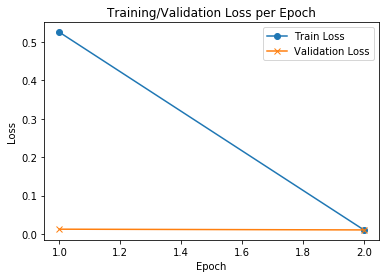

original dimension : 183
encoding dimension : 18


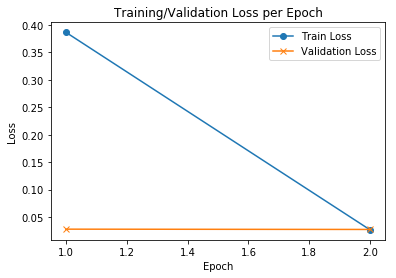

original dimension : 8
original dimension : 1068
encoding dimension : 106


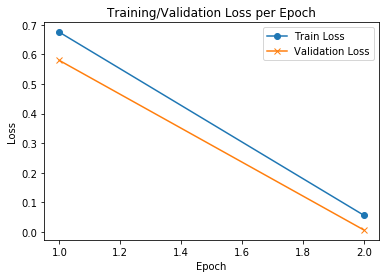

original dimension : 54
encoding dimension : 5


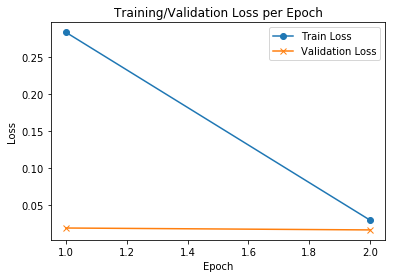

In [28]:
nb_epoch = 2  
g = F2(df_items1.group)  
p = F2(df_items1.pharmForm)  
u, u_dim = onehot2(df_items1.unit)  
m = F2(df_items1.manufacturer)  
s = F2(df_items1.salesIndex)  

In [52]:
df_items0 = pd.concat([df_items1, g, p, pd.DataFrame(u), m, s], axis=1, join_axes=[df_items1.index])  
df_items = df_items0.drop(["group", "pharmForm", "unit", "manufacturer", "salesIndex"], axis=1)
df_items.columns = [np.arange(1, (pd.DataFrame(df_items).shape[1]+1), 1)]
df_items.rename(columns={1: 'pid', 3: 'category', 4: 'rrp', 5: 'Content'}, inplace = True)
df_items.head()

,pid,2,category,rrp,Content,6,7,8,9,10,...,186,187,188,189,190,191,192,193,194,195
0,1,0,NaN,10.89,80.0,0.0,0.790775,0.0,1.794252,0.174334,...,1.078662,0.0,0.0,0.065883,1.336683,0.011546,4.244438,0.0,0.0,0.0
1,2,0,NaN,10.89,80.0,0.0,0.790775,0.0,1.794252,0.174334,...,1.078662,0.0,0.0,0.065883,1.336683,0.011546,4.244438,0.0,0.0,0.0
2,3,0,NaN,16.45,10.0,0.0,0.790775,0.0,1.794252,0.174334,...,1.078662,0.0,0.0,0.065883,1.336683,0.011546,4.244438,0.0,0.0,0.0
3,4,0,NaN,10.89,80.0,0.0,0.790775,0.0,1.794252,0.174334,...,1.078662,0.0,0.0,0.065883,1.336683,0.011546,4.244438,0.0,0.0,0.0
4,5,0,1.0,22.53,8.0,0.0,0.670131,0.0,1.543013,0.145621,...,0.976591,0.0,0.0,0.030032,1.214761,0.011546,4.244438,0.0,0.0,0.0


> 因為變數之間關聯性很小，所以分開做降維之後再合併。

In [106]:
### Filling Missing Value
df_items.category = df_items.category.fillna(value = np.mean(df_items.category))
df_items.Content = df_items.Content.fillna(value = np.mean(df_items.Content))

df_items_oh.category = df_items_oh.category.fillna(value = np.mean(df_items_oh.category))
df_items_oh.Content = df_items_oh.Content.fillna(value = np.mean(df_items_oh.Content))

# Testing set

In [60]:
df_class = pd.read_csv("class.csv", sep = "|")
print(df_class.shape)

df_class.head()

(1210767, 7)


,lineID,day,pid,adFlag,availability,competitorPrice,price
0,1,93,4772,0,1,11.54,12.04
1,2,93,11548,0,2,6.84,8.60
2,3,93,1958,0,1,9.67,10.39
3,4,93,15071,0,2,17.37,16.45
4,5,93,2117,0,1,4.94,5.45


In [61]:
missing(df_class)

Size of testing dataset : 1210767
Size of testing dataset DropNA : 1172762


lineID                 0
day                    0
pid                    0
adFlag                 0
availability           0
competitorPrice    38005
price                  0
dtype: int64

# Training set 

In [67]:
df_train0 = pd.read_csv("train.csv", sep = "|")
print(df_train0.shape)
df_train0.head()

(2756003, 11)


,lineID,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,revenue
0,1,1,6570,0,2,14.60,1,0,0,16.89,0.00
1,2,1,14922,1,1,8.57,0,1,0,8.75,0.00
2,3,1,16382,0,1,14.77,0,1,0,16.06,0.00
3,4,1,1145,1,1,6.59,0,0,1,6.55,6.55
4,5,1,3394,0,1,4.39,0,0,1,4.14,4.14


1. lineID: key for unique identification of user action  
2. adFlag: 是否廣告宣傳  
3. availability: 有貨 缺貨 可預訂 可訂製 停產  
4. competitorPrice: 對手最低價格  
5. price: 我們的售價  
6. click, basket, order, revenue:  
這一次進入網站對此商品做的事，僅僅點擊或放入購物籃或購買，造成利潤=售價*購買個數，如果僅僅點擊或放入購物籃就沒有利潤。

In [69]:
### Transfer to regression question
df_train0["number"] = df_train0["revenue"]/df_train0["price"]

### Transfer to classification question
click = df_train0[(df_train0.click == 1)]
basket = df_train0[(df_train0.basket == 1)]
order = df_train0[(df_train0.order == 1)]
click["class_label"] = 0
basket["class_label"] = 0
order["class_label"] = 1
df_train = pd.concat([click, basket, order])
df_train.head()

,lineID,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,revenue,number,class_label
0,1,1,6570,0,2,14.60,1,0,0,16.89,0.0,0.0,0
7,8,1,16963,0,1,8.78,1,0,0,8.75,0.0,0.0,0
8,9,1,14560,0,1,10.84,1,0,0,12.04,0.0,0.0,0
9,10,1,4853,1,1,9.12,1,0,0,8.75,0.0,0.0,0
11,12,1,4055,1,1,10.99,1,0,0,10.95,0.0,0.0,0


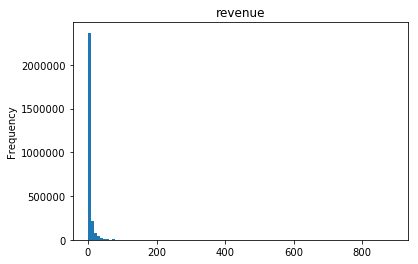

In [96]:
df_train.revenue.plot.hist(title = 'revenue', bins = 100)
plt.show()

In [70]:
print("Shape of Order = 1 :", df_train[df_train.order == 1].shape[0])
print("Shape of Order = 0 :", df_train[df_train.order != 1].shape[0])
print("Shape of Total dataset :", df_train.shape[0])

Shape of Order = 1 : 705090
Shape of Order = 0 : 2050913
Shape of Total dataset : 2756003


In [71]:
print ('Number = 0 : %.0f' % df_train[df_train.number == 0].shape[0])  
print ('Number = 1 : %.0f' % df_train[df_train.number == 1].shape[0])  
print ('Number = 2 : %.0f' % df_train[df_train.number == 2].shape[0])  
print ('Number = 3 : %.0f' % df_train[df_train.number == 3].shape[0])  
print ('Number = 4 : %.0f' % df_train[df_train.number == 4].shape[0])  
print ('Number = 5 : %.0f' % df_train[df_train.number == 5].shape[0])  
print ('Number > 5 : %.0f' % df_train[df_train.number > 5].shape[0])

Number = 0 : 2050913
Number = 1 : 562284
Number = 2 : 94381
Number = 3 : 14937
Number = 4 : 10235
Number = 5 : 6185
Number > 5 : 7358


> 因此，我們了解到如果我們做好了(0, 1)分類問題，就等於是解決了大部分的問題。

In [87]:
def vcplot(df):
    df.corr()

    plt.figure(num=None, figsize=(8, 8))
    plt.imshow(df.corr(), cmap = plt.cm.Blues, interpolation = 'nearest')
    plt.colorbar()
    tick_marks = [i for i in range(len(df.columns))]
    plt.xticks(tick_marks, df.columns, rotation = 'vertical')
    plt.yticks(tick_marks, df.columns)
    plt.title('Variance Covariance Matrix', fontsize = 12)

    plt.show()

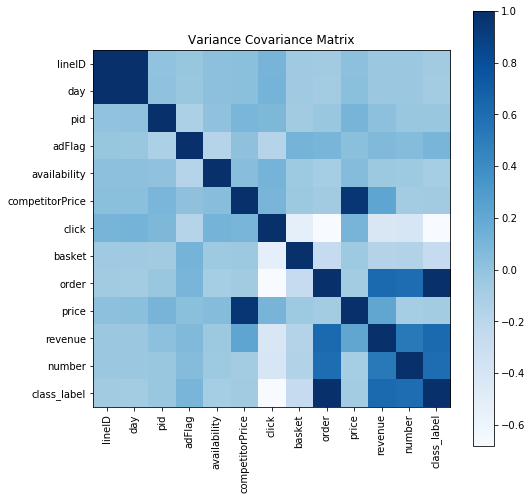

In [88]:
vcplot(df_train)

> 變數之間相關性不大，與是否購買有沒有顯著相關性。

In [83]:
table = pd.crosstab(index = df_train["availability"], columns = df_train["order"], margins = True)  
table.columns = ["non_order","order", "tol_availability"]  
table.index = ["availability1","availability2", "availability3", "availability4", "tol_order"]  
print("The Availability and Order Table")  
print(table/df_train.shape[0])

The Availability and Order Table
               non_order     order  tol_availability
availability1   0.668401  0.244360          0.912761
availability2   0.057407  0.009790          0.067197
availability3   0.014602  0.001688          0.016289
availability4   0.003752  0.000001          0.003753
tol_order       0.744162  0.255838          1.000000


In [84]:
table = pd.crosstab(index = df_train["adFlag"], columns = df_train["order"], margins = True)  
print("The adFlag and Order Table")  
print(table/df_train.shape[0])

The adFlag and Order Table
order          0         1       All
adFlag                              
0       0.528827  0.153384  0.682211
1       0.215335  0.102454  0.317789
All     0.744162  0.255838  1.000000


> 有無打廣告差很多，商品存貨狀態也是。

In [93]:
### Filling Missing Value
df_train.competitorPrice = df_train.competitorPrice.fillna(value = np.mean(df_train.competitorPrice))

# Combine Train and Items, and Hold Out Result

In [108]:
result0 = pd.merge(df_train, df_items, how='inner', on=['pid']) #df_items_oh
result0 = result0.sort_values(['lineID'], ascending = True)

##################################################### hold on last month
hold_result = result0[result0.day > 65]
hold_result = hold_result.reset_index(drop = True)

result = result0[result0.day <= 65]
result = result.reset_index(drop = True)

print('Number of hold_result: %d' % hold_result.shape[0])
print('Number of result trainig: %d' % result.shape[0])
result.head()

Number of hold_result: 889940
Number of result trainig: 1866063


,lineID,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,...,186,187,188,189,190,191,192,193,194,195
0,1,1,6570,0,2,14.60,1,0,0,16.89,...,1.046115,0.0,0.0,0.037388,1.273642,0.011546,4.244438,0.0,0.0,0.0
1,2,1,14922,1,1,8.57,0,1,0,8.75,...,1.068649,0.0,0.0,0.020120,1.319577,0.011546,4.244438,0.0,0.0,0.0
2,3,1,16382,0,1,14.77,0,1,0,16.06,...,1.015012,0.0,0.0,0.023562,1.245092,0.258308,6.122163,0.0,0.0,0.0
3,4,1,1145,1,1,6.59,0,0,1,6.55,...,1.016197,0.0,0.0,0.048767,1.244417,0.011546,4.244438,0.0,0.0,0.0
4,5,1,3394,0,1,4.39,0,0,1,4.14,...,1.043700,0.0,0.0,0.029742,1.259859,0.258308,6.122163,0.0,0.0,0.0


## training time (base line: 73.23%)

In [110]:
X = result.drop(["class_label", "number", "click", "basket", "order", "revenue"], axis = 1)
Y = result[["class_label", "number"]]

### standardized X
columns_conti = ["lineID","day","pid","competitorPrice","price","category","rrp","Content"]
X_conti = X[columns_conti]
sc = StandardScaler(copy=True, with_mean = True, with_std = True)
X_std = pd.DataFrame(sc.fit_transform(X_conti), columns = columns_conti)
X_cate = X.drop(columns_conti, axis = 1)
X = pd.concat([X_std, X_cate], axis=1)
X.head()

,lineID,day,pid,competitorPrice,price,category,rrp,Content,adFlag,availability,...,186,187,188,189,190,191,192,193,194,195
0,-1.732050,-1.958201,-0.602422,0.153581,0.230951,0.840832,0.002081,-0.143097,0,2,...,1.046115,0.0,0.0,0.037388,1.273642,0.011546,4.244438,0.0,0.0,0.0
1,-1.732048,-1.958201,0.689669,-0.334932,-0.371538,-0.538213,0.032538,-0.143097,1,1,...,1.068649,0.0,0.0,0.020120,1.319577,0.011546,4.244438,0.0,0.0,0.0
2,-1.732046,-1.958201,0.915537,0.167354,0.169518,-0.820537,0.014590,-0.033341,0,1,...,1.015012,0.0,0.0,0.023562,1.245092,0.258308,6.122163,0.0,0.0,0.0
3,-1.732044,-1.958201,-1.441693,-0.495339,-0.534373,-0.983416,-0.484151,-0.121146,1,1,...,1.016197,0.0,0.0,0.048767,1.244417,0.011546,4.244438,0.0,0.0,0.0
4,-1.732042,-1.958201,-1.093763,-0.673569,-0.712751,-1.102861,-0.548330,-0.143097,0,1,...,1.043700,0.0,0.0,0.029742,1.259859,0.258308,6.122163,0.0,0.0,0.0


In [115]:
def split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    print('Number of training: %d' % X_train.shape[0])
    print('Number of testing: %d' % X_test.shape[0])
    return X_train, X_test, y_train, y_test

In [117]:
def cross_val(model, number_cv):
    scores_dt0 = cross_val_score(model, X_train, y_train, cv = number_cv, n_jobs = 4)  
    scores_dt = np.sum(scores_dt0) / number_cv
    
    print("===cross_val===")  
    print(scores_dt)  

In [118]:
X_train, X_test, y_train, y_test = split(X, Y["number"])

Number of training: 1492850
Number of testing: 373213


## RandomForestRegressor

In [119]:
rfr = RandomForestRegressor(n_estimators = 100, 
                            max_features = 'log2', 
                            criterion = 'mse', 
                            max_depth = None, 
                            min_samples_split = 20, 
                            min_samples_leaf = 10, 
                            min_weight_fraction_leaf = 0.0, 
                            max_leaf_nodes = None, 
                            min_impurity_split = 1e-07, 
                            bootstrap = True, 
                            oob_score = True, 
                            n_jobs = 1, 
                            random_state = 0, 
                            verbose = 0, 
                            warm_start = False)

In [122]:
#cross_val(rfr, 5)

In [ ]:
rfr.fit(X_train, y_train)
pred = rfr.predict(X_test).reshape(y_test.shape[0], 1)  
print(rfr.oob_score_)

score = np.dot((pred - y_test).T, (pred - y_test))  
print("===Euclidean Distance===")  
print(score[0, 0])  

a = pd.DataFrame(np.concatenate((np.array(y_test), pred), axis=1))  
a.columns = ["test", "pred"]  

a.plot.scatter(x = 'test', y = 'pred', s = 10, alpha = 0.2)  
plt.show()  

> order = 1  
14368734.289, 0.557460340944    
11113583.7032, new

## DecisionTreeClassifier

In [120]:
def classification_processing(model):
    model.fit(X_train, y_train)
    print("training down")
    y_pred = model.predict(X_test).reshape(y_test.shape[0], 1)
    print('Misclassified samples: %d' % (y_test != y_pred).sum())
    print('Accuracy : %.2f' % ((y_test == y_pred).sum() / y_test.shape[0]))
    print('Accuracy (sklearn): %.2f' % accuracy_score(y_test, y_pred))
    print("==confusion matrix==")
    print(confusion_matrix(y_test, y_pred, labels = [0,1], sample_weight = None))

In [124]:
X_train, X_test, y_train, y_test = split(X, Y["class_label"])

Number of training: 1492850
Number of testing: 373213


In [125]:
tree = DecisionTreeClassifier(criterion = 'entropy', 
                              max_depth = 3, 
                              random_state = 0,
                              class_weight = {1: (len(click) + len(basket))/len(order), 0: 1.0})

In [ ]:
print("===Decision Tree===")
classification_processing(tree)

===Decision Tree===
training down


## BaggingClassifier

In [67]:
from sklearn.ensemble import BaggingClassifier  
bc = BaggingClassifier(base_estimator = tree,  
                       n_estimators = 10,  
                       max_samples = 1.0,  
                       max_features = 1.0,  
                       bootstrap = True,  
                       bootstrap_features = False,  
                       oob_score = False,  
                       warm_start = False,  
                       n_jobs = 1,  
                       random_state = None,  
                       verbose = 0)    

In [68]:
print("===Bagging===")
classification_processing(bc)

===Bagging===


/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


training down
Misclassified samples: 1934
Accuracy : 0.43
Accuracy (sklearn): 0.43
==confusion matrix==
[[ 222 1922]
 [  12 1238]]


## AdaBoostClassifier

In [69]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(base_estimator = tree,
                         n_estimators=50,
                         learning_rate=1.0,
                         algorithm='SAMME.R',
                         random_state=None)

In [70]:
print("===AdaBoost===")
classification_processing(abc)

===AdaBoost===


/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


training down
Misclassified samples: 1656
Accuracy : 0.51
Accuracy (sklearn): 0.51
==confusion matrix==
[[ 712 1432]
 [ 224 1026]]
